In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import re
import os
%matplotlib inline

In [14]:
INCLUDE_SWIFT_LONG_LIBS = True
WORKFLOW_BRANCH = "b"

# Analysis plots for alternative workflow branch

The "b" workflow includes a re-processing of the data with downsampling based on coverage instead of read count.

This notebook recreates many plots that are produced in other notebooks for the main workflow (downsample based on read count).

The code is copy/pasted from the original notebooks, then condensed to produce only the most important plots, and adjusted for alternative file naming.

The `savefig` function in this notebook writes a figure with file name prefix `b_`.

# General plots, from Main_analysis notebook

In [15]:
def load_picard(path):
    with open(path) as f:
        mode = None
        metrics_header = None
        metrics_data = {}
        histogram_series = []
        histogram_data = []
        for l in f:
            line = l.rstrip("\r\n")
            if mode == 'metrics':
                metrics_header = line.split()
                mode = 'metrics2'
            elif mode == 'metrics2':
                if line != "":
                    metrics_data = dict(zip(metrics_header, line.split()))
                else:
                    mode = None
            elif mode == 'histogram':
                histogram_series = line.split()
                histogram_data = [list() for _ in histogram_series]
                mode = 'histogram2'
            elif mode == 'histogram2':
                if line != "":
                    for i, value in enumerate(line.split()):
                        histogram_data[i].append(value)
                else:
                    mode = None
            elif line.startswith("## METRICS CLASS"):
                mode = 'metrics'
            elif line.startswith("## HISTOGRAM"):
                mode = 'histogram'
        if histogram_series:
            #metrics_data['histograms'] = dict(zip(histogram_series, histogram_data))
            for name, data in zip(histogram_series, histogram_data):
                metrics_data[name] = [float(x) for x in data]
    return metrics_data
samples = []
for bam in glob("{}30_downsample/*_DS_MD.AlignmentSummaryMetrics.txt".format(WORKFLOW_BRANCH)):
    basepath = re.sub(r"_MD\.AlignmentSummaryMetrics\.txt$", "", bam)
    data = {}
    try:
        for metrics in ['_MD.AlignmentSummaryMetrics', '_MD.InsertSizeMetrics',
                        '.MarkDuplicatesMetrics', '_MD.WgsMetrics']:
            new_data = load_picard("{}{}.txt".format(basepath, metrics))
            if any(k in data for k in new_data):
                print("Duplicate key {} found in {}".format(k, metrics))
            data.update(new_data)
    except FileNotFoundError as e:
        print("File {} not found, skipping this sample.".format(e.filename))
        continue
    samples.append(data)

print("Sample count", len(samples))
inital_read_counts = []
for alignment_txt in glob("20_piccard/*.AlignmentSummaryMetrics.txt"):
    library = re.match(r"([^/]+)\.AlignmentSummaryMetrics.txt", os.path.basename(alignment_txt)).group(1)
    new_data = load_picard(alignment_txt)
    inital_read_counts.append({'LIBRARY': library, 'INITIAL_READS': int(new_data['TOTAL_READS']),
                                    'INITIAL_READS_PER_END': int(new_data['TOTAL_READS']) / 2,
                                    'INITIAL_READS_ALIGNED': int(new_data['PF_READS_ALIGNED']),
                                    'INITIAL_READS_ALIGNED_PER_END': int(new_data['PF_READS_ALIGNED']) / 2})
    
main_df = pd.DataFrame(samples).reindex().apply(pd.to_numeric, axis=0, errors='ignore')
in_reads_df = pd.DataFrame(inital_read_counts)

df = pd.merge(
        main_df, 
        in_reads_df,  
        on='LIBRARY')
df['Kit'] = pd.Categorical(df.LIBRARY.str.split("-").str.get(0))
df['Conc'] = pd.Categorical(df.LIBRARY.str.split("-").str.get(1), categories=['10ng', '100ng'])
if not INCLUDE_SWIFT_LONG_LIBS:
    df = df.loc[df.Kit != "Swiftlong"]
    df.Kit = df.Kit.cat.set_categories(['Kapa', 'NEB', 'Nextera', 'Quanta', 'Swift2S'])
else:
    df.Kit = df.Kit.cat.set_categories(['Kapa', 'NEB', 'Nextera', 'Quanta', 'Swift2S', 'Swiftlong'])
    df_100 = df.loc[df.Conc == "100ng"]
df.head(n=1)
print("Number of entries: ", len(df))



def savefig(name, main=True):
    if main:
        if INCLUDE_SWIFT_LONG_LIBS:
            plt.savefig('plots-main-withLong/b_{}'.format(name))
        else:
            plt.savefig('plots-main/b_{}'.format(name))
    else:
        if INCLUDE_SWIFT_LONG_LIBS:
            plt.savefig('plots-suppl-withLong/b_{}'.format(name))
        else:
            plt.savefig('plots-suppl/b_{}'.format(name))

Sample count 3
Number of entries:  3


Text(0.5, 1.0, 'Downsampled reads')

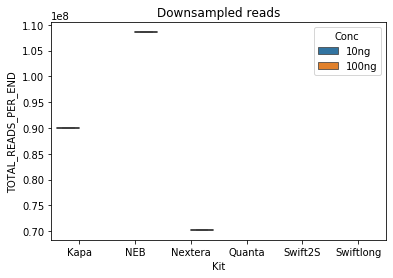

In [16]:
df['TOTAL_READS_PER_END'] = df['TOTAL_READS'] / 2
sns.boxplot(data=df, x='Kit', y='TOTAL_READS_PER_END', hue='Conc')
plt.title('Downsampled reads')

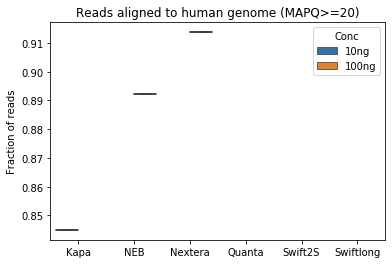

In [17]:
df['PCT_HQ_PF_READS_ALIGNED'] = df.PF_HQ_ALIGNED_READS / df.TOTAL_READS
sns.boxplot(data=df, x='Kit', y='PCT_HQ_PF_READS_ALIGNED', hue='Conc')
plt.title('Reads aligned to human genome (MAPQ>=20)')
plt.ylabel("Fraction of reads")
plt.xlabel("")
savefig("aligned_reads_human.pdf")

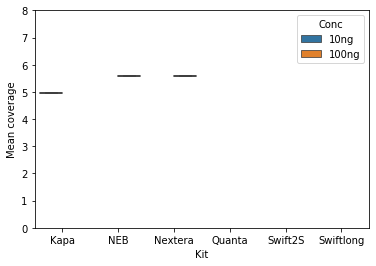

In [18]:
sns.boxplot(data=df, x="Kit", y="MEAN_COVERAGE", hue="Conc")
plt.ylim(0, 8)
plt.ylabel('Mean coverage')
savefig("b_mean_coveraage.pdf")

# Coverage, from Deeptoos_coverage_analysis

10ng


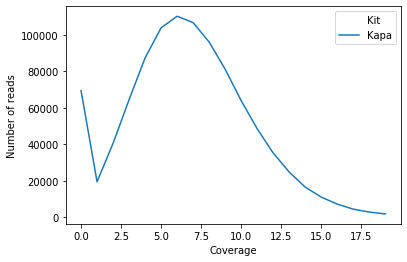

100ng


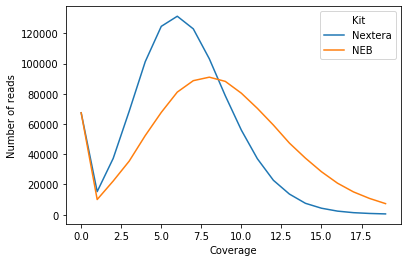

In [19]:
for conc in ["10ng", "100ng"]:
    print(conc)
    cov_matrix = pd.read_csv("{}50_deeptools_summary/coverage_{}.txt".format(WORKFLOW_BRANCH, conc), skiprows=1, sep='\t')
    cov_matrix.columns = [
        c.replace("'", "").replace("_DS_MD.bam", "")
        for c in cov_matrix.columns
    ]
    if not INCLUDE_SWIFT_LONG_LIBS:
        cov_matrix = cov_matrix[[c for c in cov_matrix.columns if not c.startswith("Swiftlong")]]
    columns = cov_matrix.columns[3:]
    counts_matrix = cov_matrix.iloc[:, 3:].apply(pd.value_counts)

    counts_long = counts_matrix.reset_index().rename({'index': 'Coverage'}, axis=1).melt(id_vars=['Coverage'], value_name="NumReads")
    counts_long['Kit'] = counts_long.variable.str.split("-").str.get(0)
    counts_long['Replicate'] = counts_long.variable.str.split("-").str.get(2)
    #counts_long = counts_long.groupby(['Kit', 'Replicate']).apply(reverse_cum_sum)
    counts_medium = counts_long[counts_long.Coverage < 20]
    plt.figure()
    sns.lineplot(x='Coverage', y='NumReads', hue='Kit', data=counts_medium)
    plt.ylabel("Number of reads")
    savefig("coverage_deeptools_{}.pdf".format(conc))
    plt.show()

# Insert sizes, from same NB

In [20]:
# Pretty if n_boot ~ 3000, ugly but fast if around 50
n_boot = 3333

10ng


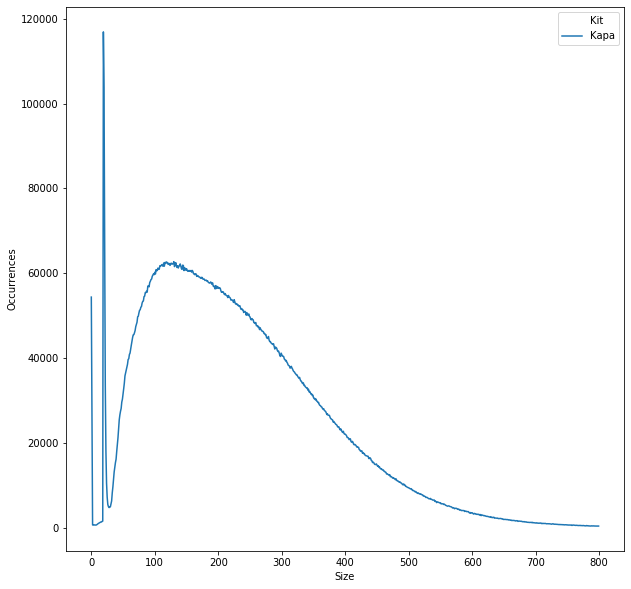

100ng


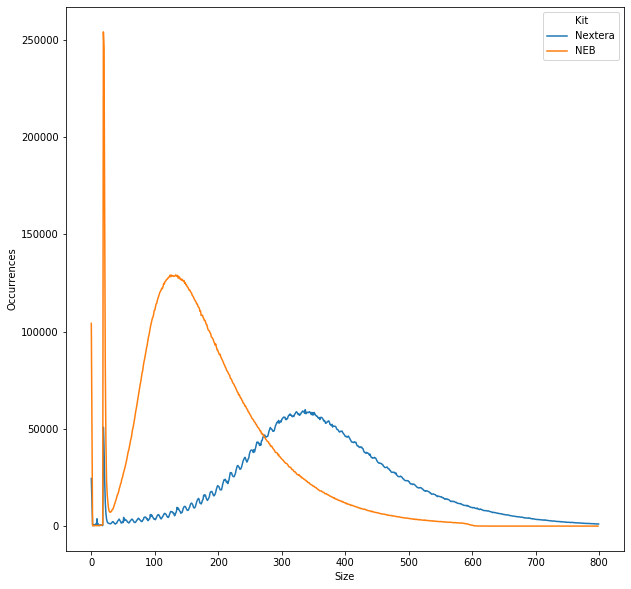

In [21]:
insertSizeDatas = [pd.read_csv(
                        "{}50_deeptools_summary/insertSize_{}.txt".format(WORKFLOW_BRANCH, conc),
                        sep="\t", skiprows=1
                        ).assign(Conc=conc)
                   for conc in ["10ng", "100ng"]]

insertSizeData = pd.concat(insertSizeDatas)
insertSizeData[['Kit', 'Replicate']] = insertSizeData.Sample.str.extract(r"([a-zA-Z0-9]+)-100?ng-([1234])")
if not INCLUDE_SWIFT_LONG_LIBS:
    insertSizeData = insertSizeData[insertSizeData.Kit != 'Swiftlong']
shorterInsertSize = insertSizeData[insertSizeData.Size < 800]
for conc in ["10ng", "100ng"]:
    print(conc)
    plt.figure(figsize=(10,10))
    sns.lineplot(x="Size", y="Occurrences", hue="Kit", data=shorterInsertSize[shorterInsertSize.Conc == conc], n_boot=n_boot)
    savefig("insert_size_deeptools_{}.pdf".format(conc))
    plt.show()

# GC content not recomputed

It requires Qualimap. Not done for this workflow branch, see the main workflow, which downsamples based on number of reads. Notebook Deeptools_coverage_analysis.

In [22]:
#gc_content_files = glob(os.path.join("30_downsample", "qualimap", "*-aa_DS", "raw_data_qualimapReport", "mapped_reads_gc-content_distribution.txt"))
#gc_data = pd.concat(map(lambda x: pd.read_csv(x, sep="\t").assign(File=x), gc_content_files))
#gc_data.head(n=1)
#sample_file_name = lambda path: os.path.basename(os.path.dirname(os.path.dirname(path)))
#gc_data['Kit'] = pd.Categorical(gc_data.File.apply(lambda x: sample_file_name(x).split("-")[0]))
#gc_data['Conc'] = pd.Categorical(gc_data.File.apply(lambda x: sample_file_name(x).split("-")[1]))
#gc_data['Replicate'] = pd.Categorical(gc_data.File.apply(lambda x: sample_file_name(x).split("-")[2]))
#gc_data.head(n=1)
#for conc in ["10ng", "100ng"]:
#    sns.lineplot(data=gc_data[
#                            (gc_data.Conc == conc) & 
#                            (gc_data["#GC Content (%)"] > 10) & 
#                            (gc_data["#GC Content (%)"] < 80)
#                            ], 
#                 x="#GC Content (%)", y="Sample", hue="Kit")
#    plt.xlabel("GC content (%)")
#    plt.ylabel("Fraction of mapped reads")
#    savefig("gc_content_{}.pdf".format(conc))
#    print(conc)
#    plt.show()

# Variant calling plots -- from NB variant_calling

In [23]:
files = glob(f"{WORKFLOW_BRANCH}50_variant_analysis/*/*.roc.all.csv.gz")
dataframes = []
for file in files:
    m = re.search(r"([^/]+)-(100?ng)-(\d)\.", file)
    kit, conc, rep = m.groups()
    if not INCLUDE_SWIFT_LONG_LIBS and kit == "Swiftlong":
        continue
    data = pd.read_csv(file)
    data = data[(data.Filter=="ALL") & (data['QQ.Field'] == "CNN_2D") 
                  & (data['QQ'] != '*') & (data.Subset == "*") & (data.Subtype == "*")]
    cols = ["METRIC.Recall", "METRIC.Precision", "QQ"]
    data = data[cols].apply(pd.to_numeric, axis=1).assign(Type=data.Type)
    data = data[data['METRIC.Recall'] > 0.01]
    data['Kit'] = kit
    data['Conc'] = conc
    data['Replicate'] = rep
    dataframes.append(data)
data = pd.concat(dataframes).reset_index(drop=True)
data['Kit'] = pd.Categorical(data.Kit)
data['Conc'] = pd.Categorical(data.Conc, categories=['10ng', '100ng'])
data['F1_score'] = 2*(data['METRIC.Recall'] * data['METRIC.Precision']) / (data['METRIC.Recall'] + data['METRIC.Precision'])

In [24]:
def get_min_qq_row_for_replicate(group_df):
    return group_df.loc[group_df.QQ.idxmin()]

def get_mean_over_replicates(l):
    return l.groupby("Replicate").apply(get_min_qq_row_for_replicate).mean()

quality_thres_mean = data[data.QQ > -5].groupby(["Type", "Kit", "Conc"]).apply(
            get_mean_over_replicates
        )
summary = quality_thres_mean[["METRIC.Recall", "METRIC.Precision", "QQ", "F1_score"]]
summary.to_csv("result-tables/b_vc-performance-summary.txt")
summary

KeyError: "None of [Index(['METRIC.Recall', 'METRIC.Precision', 'QQ', 'F1_score'], dtype='object')] are in the [columns]"

In [ ]:
def get_replicates(l):
    return l.groupby("Replicate", as_index=False).apply(get_min_qq_row_for_replicate)

box_data = data[data.QQ > -5].groupby(["Type", "Kit", "Conc"], as_index=False).apply(get_replicates)

plt.figure()
sns.boxplot(data=box_data[box_data.Type == "SNP"], x="Kit", y="F1_score", hue="Conc")
savefig("vc_snv_qthresh_mean_f1.pdf")
plt.figure()
sns.boxplot(data=box_data[box_data.Type == "INDEL"], x="Kit", y="F1_score", hue="Conc")
savefig("vc_indel_qthresh_mean_f1.pdf")

In [ ]:
# Primary code in development, and series definition
newrecall = pd.Index(np.linspace(0, 1, num=201))
def resample(groupdata):
    dedup = groupdata.drop_duplicates('METRIC.Recall')
    # Create series with all recall values as index, both original ones and ones at fixed interval
    precision_values = dedup.set_index('METRIC.Recall')['METRIC.Precision'].reindex(
        pd.Index(dedup['METRIC.Recall']).union(newrecall)
    )
    # Resulting series contains recall as index and precision as values, and only the new
    # recall values, not the original values. (See above cell for newrecall)
    precision_series = precision_values.interpolate(method='values').loc[newrecall]
    # Blank all values after the last known data point (default is to set these to the last
    # sensitivity value)
    max_data_precision = dedup['METRIC.Recall'].max()
    precision_series[precision_series.index > max_data_precision] = np.nan
    precision_series.index.name = 'METRIC.Recall'
    # Data frame to return:
    return precision_series.to_frame()
resampled_df1 = data.groupby(["Type", "Conc", "Kit", "Replicate"]).apply(resample)
resampled_df = resampled_df1.groupby(level=['Type', 'Conc', 'Kit', 'METRIC.Recall']).apply( # Note: not "Replicate" lvl
        # The second clause in the ternary returns a dataframe with all NaNs
        lambda d: d if not d['METRIC.Precision'].hasnans else pd.DataFrame().reindex_like(d)
)

In [ ]:
for conc in ["10ng", "100ng"]:
    plt.figure(figsize=(10,10))
    g = sns.lineplot(y="METRIC.Precision", x="METRIC.Recall", hue="Kit",
                     n_boot=n_boot,
                     data=resampled_df.loc[('SNP', conc)].reset_index())
    plt.ylim(0.9, 1.0)
    plt.xlim(0.0, 0.95)
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title("SNV (conc = {})".format(conc))
    savefig("snv_rs_{}.pdf".format(conc))
    plt.show()

In [ ]:
for conc in ["10ng", "100ng"]:
    plt.figure(figsize=(10,10))
    g = sns.lineplot(y="METRIC.Precision", x="METRIC.Recall", hue="Kit",
                     n_boot=n_boot, data=resampled_df.loc[('INDEL', conc)].reset_index())
    plt.ylim(0.55, 1.0)
    plt.xlim(0.0, 0.75)
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title("INDEL (conc = {})".format(conc))
    savefig("indel_rs_{}.pdf".format(conc))
    plt.show()